In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import Imputer, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import joblib
from random import randint
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import itertools

In [4]:
Housing_price=pd.read_csv('../data/kc_house_data.csv') #, sep=',', encoding='iso-8859-1', low_memory=False)
cols = [i for i in Housing_price.columns if i not in ['date']]
for col in cols:
    Housing_price[col] = pd.to_numeric(Housing_price[col], errors = 'coerce')
#Housing_price['date']=Housing_price['date'][0:8] 
#Housing_price['date']=Housing_price['date'].str.extract(r'^(\d{8})', expand=False)
#Housing_price['date'] = pd.to_datetime(Housing_price['date'])
Housing_price['unit_price']=Housing_price['price']/(Housing_price['sqft_above']+Housing_price['sqft_basement']+Housing_price['sqft_lot']+Housing_price['sqft_living'])
#Housing_price=Housing_price.drop(['id', 'waterfront', 'view', 'yr_renovated', 'yr_built', 'zipcode', 'sqft_living15', 'sqft_lot15', 'sqft_above', 'sqft_basement'], axis=1)

In [5]:
#Housing_price=Housing_price.drop(['DOM', 'followers', 'kitchen','communityAverage'], axis=1)

In [6]:
Housing_price.head()

,Unnamed: 0,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft,AnomalyScore,unit_price
0,0,32.489019,3,1.00,1180,5650,1,0,0,3,...,1180,0,1955,0,98178,47.5112,-122.257,6830,0,0.004056
1,1,54.830819,3,2.25,2570,7242,2,0,0,3,...,2170,400,1951,1991,98125,47.7210,-122.319,9812,0,0.004428
2,2,16.713092,2,1.00,770,10000,1,0,0,3,...,770,0,1933,0,98028,47.7379,-122.233,10770,0,0.001448
3,3,86.781609,4,3.00,1960,5000,1,0,0,5,...,1050,910,1965,0,98136,47.5208,-122.393,6960,0,0.009729
4,4,52.254098,3,2.00,1680,8080,1,0,0,3,...,1680,0,1987,0,98074,47.6168,-122.045,9760,0,0.004568


In [7]:
Housing_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20818 entries, 0 to 20817
Data columns (total 21 columns):
Unnamed: 0       20818 non-null int64
price            20818 non-null float64
bedrooms         20818 non-null int64
bathrooms        20818 non-null float64
sqft_living      20818 non-null int64
sqft_lot         20818 non-null int64
floors           20818 non-null int64
waterfront       20818 non-null int64
view             20818 non-null int64
condition        20818 non-null int64
grade            20818 non-null int64
sqft_above       20818 non-null int64
sqft_basement    20818 non-null int64
yr_built         20818 non-null int64
yr_renovated     20818 non-null int64
zipcode          20818 non-null int64
lat              20818 non-null float64
long             20818 non-null float64
sqft             20818 non-null int64
AnomalyScore     20818 non-null int64
unit_price       20818 non-null float64
dtypes: float64(5), int64(16)
memory usage: 3.3 MB


# Data Exploration

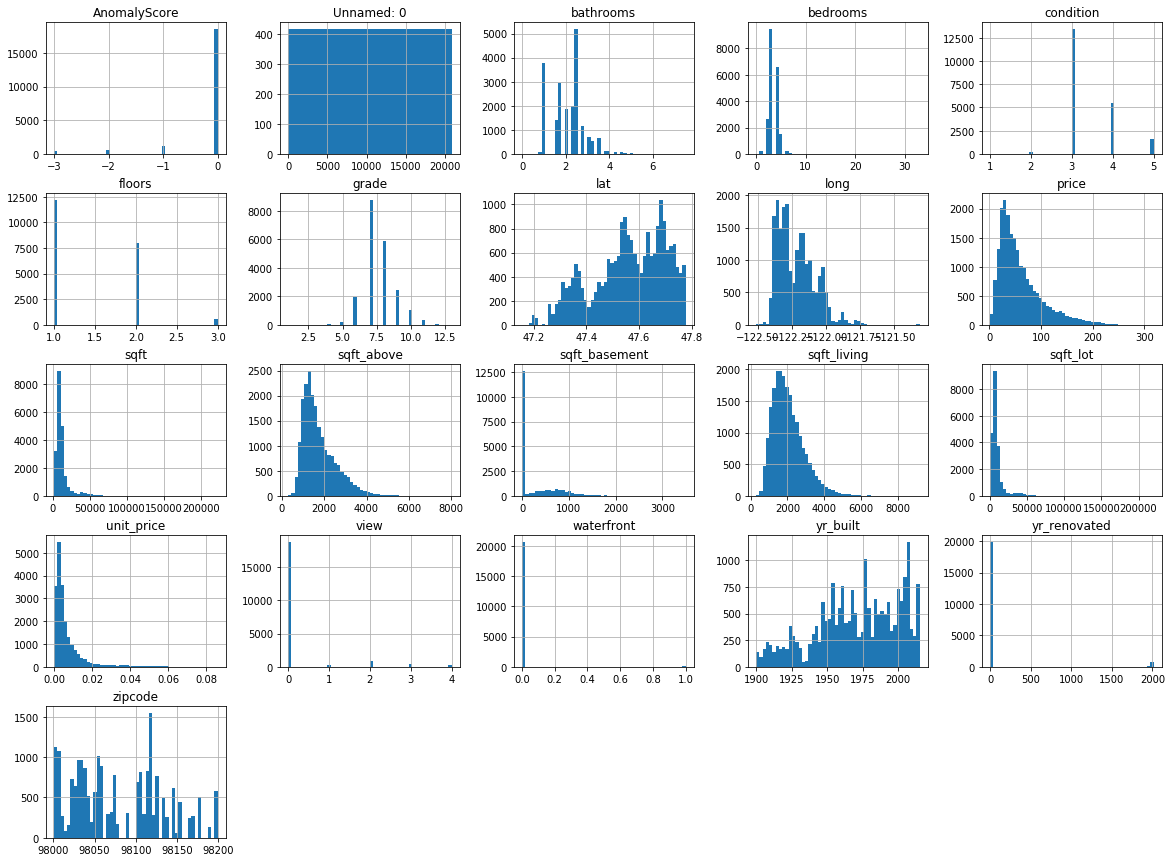

In [8]:
Housing_price.hist(bins=50, figsize=(20,15))
plt.show()

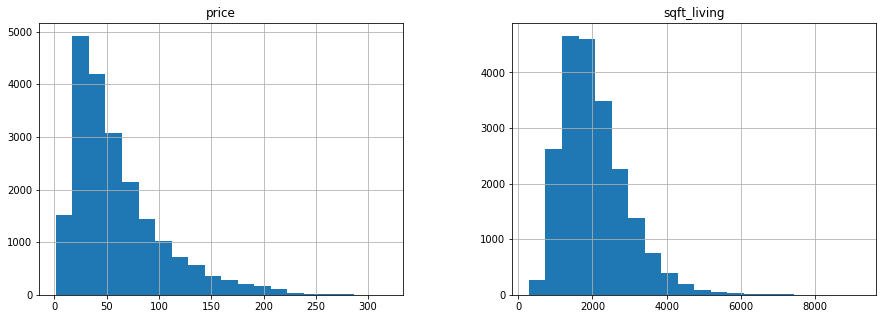

In [9]:
Housing_price.hist(['price','sqft_living'], bins=20, figsize=(15,5))
plt.savefig('hist_kc.png')
plt.show()

In [10]:
print(Housing_price.columns)

Index(['Unnamed: 0', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft', 'AnomalyScore', 'unit_price'],
      dtype='object')


No handles with labels found to put in legend.


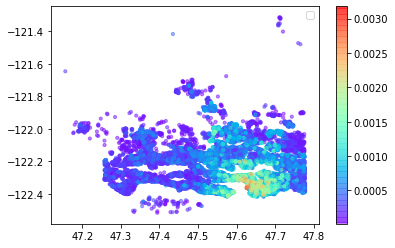

In [11]:
fig = plt.scatter(x=Housing_price['lat'], y=Housing_price['long'], alpha=0.5, \
    #s=Housing_price['price']/10000, label='Price', \
                  s=10,\
    c=Housing_price['price']/100000, cmap=plt.get_cmap('rainbow'))
plt.colorbar(fig)
plt.legend()
plt.savefig('KCheatmap.png')
plt.show()

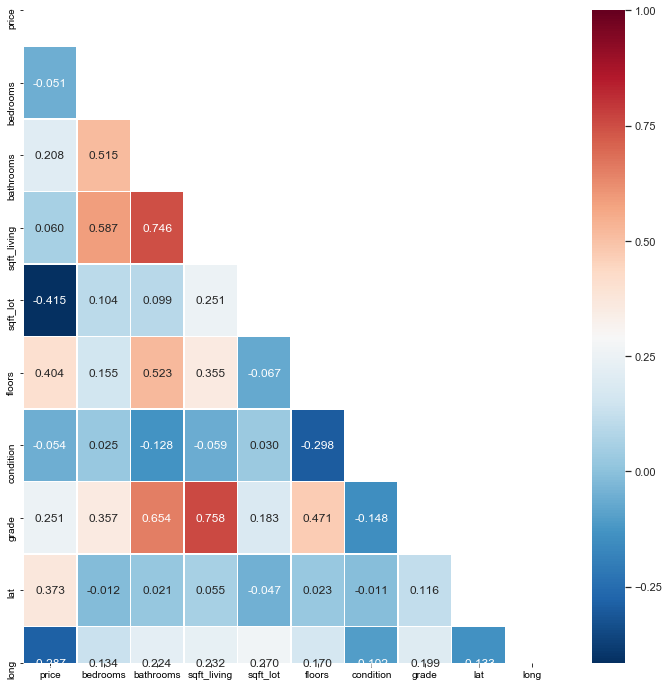

In [12]:
f,ax = plt.subplots(figsize=(12, 12))

corr = Housing_price[['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'condition', 'grade', 'lat', 'long']].corr()
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True
sns.set(style='white')
sns.heatmap(corr, mask = mask, cmap="RdBu_r", annot = True, linewidth = .5, fmt = ".3f",ax = ax)
plt.savefig('correlation_KC.png')

In [13]:
avg_price_by_trade_time= pd.DataFrame()
avg_price_by_trade_time['unit_price'] = Housing_price['unit_price']
avg_price_by_trade_time.index = Housing_price['date'].astype('datetime64[ns]')
avg_price_by_trade_month = avg_price_by_trade_time.resample('M').mean().to_period('M').fillna(60000)
avg_price_by_trade_month.plot(kind='line')
plt.ylim(0, 60)
plt.savefig('Price_trend.png')
plt.show()

KeyError: 'date'

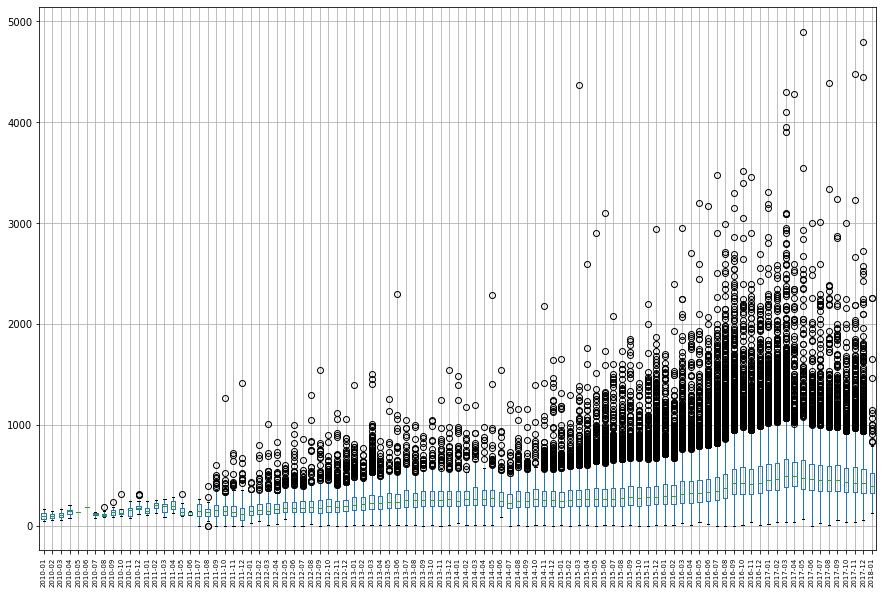

In [21]:
price_stat_trade_month_index = [x.strftime('%Y-%m') for x in set(price_by_trade_time.to_period('M').index)]
price_stat_trade_month_index.sort()
price_stat_trade_month = []
for month in price_stat_trade_month_index:
    price_stat_trade_month.append(price_by_trade_time[month]['totalPrice'].values)
price_stat_trade_month = pd.DataFrame(price_stat_trade_month)
price_stat_trade_month.index = price_stat_trade_month_index
price_stat_trade_month = price_stat_trade_month.T
price_stat_trade_month.boxplot(figsize=(15,10))
plt.xticks(rotation=90,fontsize=7)
plt.show()

# Making traing and testing data set

In [10]:
from sklearn.preprocessing import scale

In [11]:
X=Housing_price.drop(['date','price', 'floors', 'condition', 'grade'], axis=1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(scale(np.array(X)), scale(np.array(Housing_price['price'])), test_size=0.3, random_state=27)


In [12]:
X.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,lat,long
0,3,1.00,1180,5650,47.5112,-122.257
1,3,2.25,2570,7242,47.7210,-122.319
2,2,1.00,770,10000,47.7379,-122.233
3,4,3.00,1960,5000,47.5208,-122.393
4,3,2.00,1680,8080,47.6168,-122.045


In [115]:
print(y_test[0:100])

[-0.49599255 -0.79017533 -0.6539796  -0.5996375  -0.45200133  0.16319479
 -0.26445981 -0.23177283 -0.79031152 -0.79834707  0.43558625 -0.64308394
  0.72159728 -0.4751546   1.23914106 -0.57239835 -0.91275149  0.2489981
  0.46282539 -0.51778387 -0.85827319 -0.92637106 -0.36115878  6.70058986
 -0.7847275  -0.79031152 -0.77410423  0.78043384 -0.55047084 -0.47964906
 -0.92637106 -0.9536102  -0.46330557  0.62660348  0.52547543  0.12233607
 -0.23449675 -0.68135494  0.70795047 -0.49381342 -0.58588173 -0.49054472
 -0.25356415 -0.49054472 -0.36115878  0.02699906 -0.24539241 -0.17743074
 -0.2998707  -0.63913426 -0.23177283 -0.40337945  0.19029774 -0.08958449
 -0.83103405  0.29939052  0.50368411 -0.47964906  1.60959345 -0.70845789
  1.11996979 -0.13643582 -0.60767305  0.23129265  0.84417344  0.88503216
 -0.72480138 -0.26309785  0.45192973 -0.27263155 -0.99446892  1.38895636
  0.87141259  1.6749674  -0.40882728 -0.74931661  1.38895636 -0.04109881
 -0.03292707 -0.10102493  0.02699906 -0.33528159 -0.

# Model 1: Linear Regression

In [13]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)
print(reg.coef_)
print(reg.intercept_)
reg_pred_train = reg.predict(X_train)
reg_pred_test = reg.predict(X_test)

from sklearn.metrics import mean_squared_error
print("train error: " + str(mean_squared_error(y_train, reg_pred_train)))
print("test error:  " + str(mean_squared_error(y_test, reg_pred_test)))

[-0.12392345  0.03095001  0.75426604  0.00760821  0.25086174 -0.11497625]
-0.0019936605185099437
train error: 0.3966189423567924
test error:  0.4401454745937739


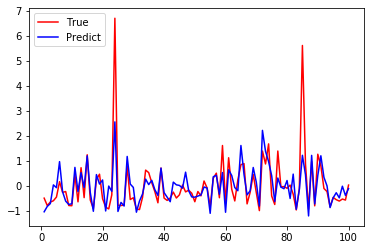

In [16]:
x = [i+1 for i in range(100)]
plt.plot(x, y_test[0:100], c='red', label='True')
plt.plot(x, reg_pred_test[0:100], c='blue', label='Predict')
plt.legend()
plt.savefig('linear_regression.png')
plt.show()

# Model 2: LinearSVR

In [7]:
lin_svm_reg = LinearSVR(C=0.5,loss='squared_epsilon_insensitive')
lin_svm_reg.fit(X_train,y_train)

NameError: name 'X_train' is not defined

In [18]:
SVM_pred_train=lin_svm_reg.predict(X_train)
SVM_pred_test=lin_svm_reg.predict(X_test)

In [6]:
print("train error: " + str(mean_squared_error(y_train, SVM_pred_train)))
print("test error:  " + str(mean_squared_error(y_test, SVM_pred_test)))

NameError: name 'lin_svm_reg' is not defined

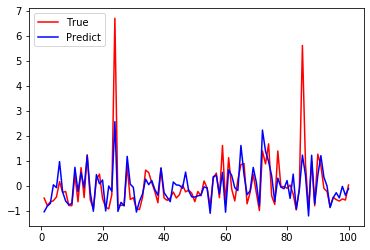

In [20]:
x = [i+1 for i in range(100)]
plt.plot(x, y_test[0:100], c='red', label='True')
plt.plot(x, SVM_pred_test[0:100], c='blue', label='Predict')
plt.legend()
plt.savefig('SVM.png')
plt.show()

# Model 5: Neural Network

In [22]:
from sklearn.neural_network import MLPRegressor
NN = MLPRegressor(learning_rate='adaptive', learning_rate_init=0.2)
NN.fit(X_train, y_train)

NN_pred_train = NN.predict(X_train)
NN_pred_test = NN.predict(X_test)
print("train error: " + str(mean_squared_error(y_train, NN_pred_train)))
print("test error:  " + str(mean_squared_error(y_test, NN_pred_test)))

train error: 0.23957097817822717
test error:  0.2725308783823197


In [33]:
NN1 = MLPRegressor(learning_rate='adaptive', learning_rate_init=0.1)
NN1.fit(X_train, y_train)

NN1_pred_train = NN1.predict(X_train)
NN1_pred_test = NN1.predict(X_test)
print("train error: " + str(mean_squared_error(y_train, NN1_pred_train)))
print("test error:  " + str(mean_squared_error(y_test, NN1_pred_test)))

train error: 0.24565386176795737
test error:  0.2757896026739661


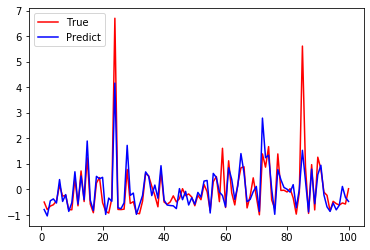

In [34]:
x = [i+1 for i in range(100)]
plt.plot(x, y_test[0:100], c='red', label='True')
plt.plot(x, NN_pred_test[0:100], c='blue', label='Predict')
plt.legend()
plt.savefig('NN')
plt.show()

In [69]:
print(NN1_pred_test[0:100])

[ 357935.84038404  250109.65336186  299967.27871042  319838.18949876
  374109.30463988  599911.73163022  442834.29455208  454859.75418975
  249931.5356742   247089.10564522  699815.87283842  303985.2880824
  804730.96596042  365668.55938624  994526.55891412  329975.64587834
  205068.02373012  631288.46351007  709630.7588752   349978.13748435
  225138.18600642  200483.76503715  407489.61322111 2998246.82747321
  252016.88226881  249972.70673881  255867.32036069  826280.0194491
  338144.27154861  363899.61090642  200028.53402901  190144.87249398
  369921.17312575  769846.64464182  732632.71430965  586696.69612848
  454496.19975274  289980.14811566  799647.87122901  358812.00652177
  325009.09067262  359870.90646264  446837.58802474  359961.31377227
  407322.74134306  549813.66553434  450049.29371775  474967.3989713
  430415.80935725  305391.4607809   454739.55207762  392488.38695137
  609762.92852584  506950.29112559  235011.57162018  649781.6198959
  724727.20985499  363854.14206792 113

# Model 5: Time Series Prediction

In [35]:
avg_price_by_trade_time = avg_price_by_trade_time.sort_values(['date'],ascending=True)

In [36]:
avg_price_by_trade_time.head()

,price
date,
2014-05-02,437500.0
2014-05-02,790000.0
2014-05-02,675000.0
2014-05-02,555000.0
2014-05-02,440000.0


In [51]:
avg_price_by_trade_time = avg_price_by_trade_time.resample('M').mean()
avg_price_by_trade_time.head()

,price
date,
2014-05-31,538580.739758
2014-06-30,561342.863315
2014-07-31,552672.323114
2014-08-31,538183.394408
2014-09-30,530316.116243


In [52]:
avg_price_by_trade_time.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13 entries, 2014-05-31 to 2015-05-31
Freq: M
Data columns (total 1 columns):
price    13 non-null float64
dtypes: float64(1)
memory usage: 208.0 bytes


In [53]:
import seaborn as sns
sns.set(style = "darkgrid")
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from matplotlib import cm
from fbprophet import Prophet

In [54]:
forecast = avg_price_by_trade_time
forecast = forecast.rename(columns={ 'price': "y" })
forecast.reset_index(level=0, inplace=True)
forecast = forecast.rename(columns={ 'date': "ds" })

In [55]:
from scipy.stats import boxcox
forecast['y'], lam = boxcox(forecast['y'])

model = Prophet()
model.fit(forecast)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 9.


In [56]:
future = model.make_future_dataframe(periods=12, freq = 'm')
future.tail()

,ds
20,2016-01-31
21,2016-02-29
22,2016-03-31
23,2016-04-30
24,2016-05-31


In [57]:
#predicting the future model
forecast = model.predict(future)
forecast_data = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

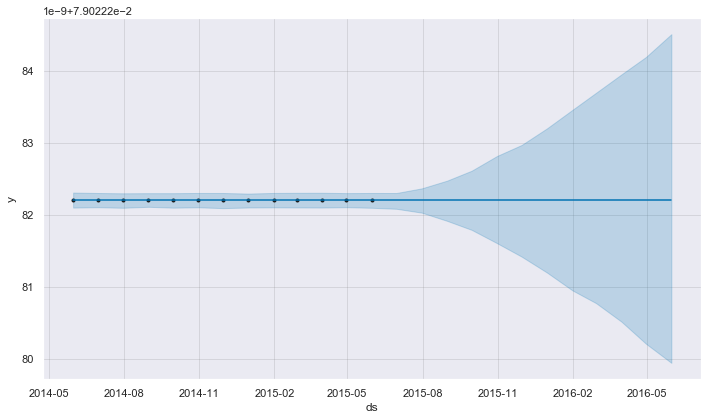

In [72]:
model.plot(forecast_data);
plt.savefig('forecast_KC.png')